# Homework 6

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [5]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [6]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


## Dataset Prepatation

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

df_filled = df.fillna(0)

y = df_filled['fuel_efficiency_mpg'].values
df_features = df_filled.drop('fuel_efficiency_mpg', axis=1)

df_train, df_full_train, y_train, y_full_train = train_test_split(df_features, y, test_size=0.4, random_state=1)
df_val, df_test, y_val, y_test = train_test_split(df_full_train, y_full_train, test_size=0.5, random_state=1)

dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
X_test = dv.transform(df_test.to_dict(orient='records'))


## Question 1

In [8]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(max_depth=1, random_state=1)
dt_reg.fit(X_train, y_train)

feature_index = dt_reg.tree_.feature[0]
split_feature = dv.feature_names_[feature_index]

print("Feature used for splitting at the root:", split_feature)


Feature used for splitting at the root: vehicle_weight


## Question 2

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_reg = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("RMSE on validation data:", rmse)

RMSE on validation data: 0.4602815367032659


## Question 3

In [15]:
rmses = []
estimators_range = range(10, 201, 10)

for n_estimators in estimators_range:
    rf_reg = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmses.append(rmse)

for n, rmse in zip(estimators_range, rmses):
    print(f"n_estimators={n}: RMSE={rmse:.3f}")

best_rmse = rmses[0]
best_n = estimators_range[0]
for n, rmse in zip(estimators_range, rmses):
    if rmse < best_rmse - 0.001:
        best_rmse = rmse
        best_n = n

print("After n_estimators =", best_n, "RMSE stops improving significantly")


n_estimators=10: RMSE=0.460
n_estimators=20: RMSE=0.446
n_estimators=30: RMSE=0.440
n_estimators=40: RMSE=0.438
n_estimators=50: RMSE=0.437
n_estimators=60: RMSE=0.436
n_estimators=70: RMSE=0.436
n_estimators=80: RMSE=0.436
n_estimators=90: RMSE=0.435
n_estimators=100: RMSE=0.435
n_estimators=110: RMSE=0.435
n_estimators=120: RMSE=0.435
n_estimators=130: RMSE=0.435
n_estimators=140: RMSE=0.435
n_estimators=150: RMSE=0.435
n_estimators=160: RMSE=0.435
n_estimators=170: RMSE=0.435
n_estimators=180: RMSE=0.435
n_estimators=190: RMSE=0.435
n_estimators=200: RMSE=0.435
After n_estimators = 60 RMSE stops improving significantly


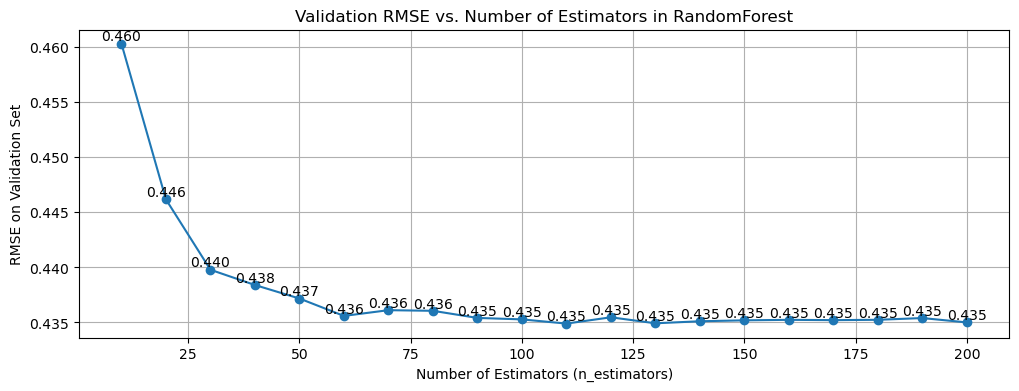

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(list(estimators_range), rmses, marker='o')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('RMSE on Validation Set')
plt.title('Validation RMSE vs. Number of Estimators in RandomForest')
plt.grid()

for n, rmse in zip(estimators_range, rmses):
    plt.text(n, rmse, f"{rmse:.3f}", ha='center', va='bottom', fontsize=10)

plt.show()

## Question 4

In [20]:
mean_rmses = {}

max_depth_values = [10, 15, 20, 25]
estimators_range = range(10, 201, 10)

for max_depth in max_depth_values:
    rmses = []
    for n_estimators in estimators_range:
        rf_reg = RandomForestRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            random_state=1,
            n_jobs=-1
        )
        rf_reg.fit(X_train, y_train)
        y_pred = rf_reg.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)
    mean_rmse = np.mean(rmses)
    mean_rmses[max_depth] = mean_rmse
    print(f"max_depth={max_depth}: mean RMSE={mean_rmse:.3f}")

best_max_depth = min(mean_rmses, key=mean_rmses.get)
print("Best max_depth:", best_max_depth)

max_depth=10: mean RMSE=0.436
max_depth=15: mean RMSE=0.438
max_depth=20: mean RMSE=0.438
max_depth=25: mean RMSE=0.438
Best max_depth: 10


## Question 5

In [21]:
rf_reg = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf_reg.fit(X_train, y_train)

importances = rf_reg.feature_importances_

feature_names = dv.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, importances))

features_to_check = ['vehicle_weight', 'horsepower', 'acceleration', 'engine_displacement']
for feature in features_to_check:
    print(f"{feature}: {feature_importance_dict.get(feature, 0):.3f}")

most_important_feature = max(features_to_check, key=lambda x: feature_importance_dict.get(x, 0))
print("Most important feature:", most_important_feature)

vehicle_weight: 0.960
horsepower: 0.016
acceleration: 0.011
engine_displacement: 0.003
Most important feature: vehicle_weight


## Question 6

In [23]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [24]:
def train_xgb(eta_value):
    xgb_params = {
        'eta': eta_value,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 0,
    }
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=100,
        evals=watchlist,
        early_stopping_rounds=10,
        verbose_eval=False
    )
    y_pred = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

In [ ]:
rmse_eta_03 = train_xgb(0.3)
rmse_eta_01 = train_xgb(0.1)

print(f"RMSE with eta=0.3: {rmse_eta_03:.3f}")
print(f"RMSE with eta=0.1: {rmse_eta_01:.3f}")

if rmse_eta_01 < rmse_eta_03:
    best_eta = 0.1
elif rmse_eta_03 < rmse_eta_01:
    best_eta = 0.3
else:
    best_eta = "both give equal value"

print("Best eta:", best_eta)

RMSE with eta=0.3: 0.427
RMSE with eta=0.1: 0.417
Best eta: 0.1
